# Importing Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.svm import  SVC
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.pipeline import make_pipeline
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 1000)


# Loading Datasets

To preserve the original training data I have made a copy of it.

In [2]:
training = pd.read_csv('../input/summeranalytics2020/train.csv')
train_data = training.copy()
test_data = pd.read_csv('../input/summeranalytics2020/test.csv')

# Basic EDA

In [3]:
train_data.head()

,Id,Age,Attrition,BusinessTravel,Department,...,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,CommunicationSkill,Behaviour
0,1,30,0,Non-Travel,Research & Development,...,7,6,7,4,1
1,2,36,0,Travel_Rarely,Research & Development,...,2,1,1,2,1
2,3,55,1,Travel_Rarely,Sales,...,7,7,3,5,1
3,4,39,0,Travel_Rarely,Research & Development,...,7,1,7,4,1
4,5,37,0,Travel_Rarely,Research & Development,...,7,7,8,1,1


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1628 entries, 0 to 1627
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Id                       1628 non-null   int64 
 1   Age                      1628 non-null   int64 
 2   Attrition                1628 non-null   int64 
 3   BusinessTravel           1628 non-null   object
 4   Department               1628 non-null   object
 5   DistanceFromHome         1628 non-null   int64 
 6   Education                1628 non-null   int64 
 7   EducationField           1628 non-null   object
 8   EmployeeNumber           1628 non-null   int64 
 9   EnvironmentSatisfaction  1628 non-null   int64 
 10  Gender                   1628 non-null   object
 11  JobInvolvement           1628 non-null   int64 
 12  JobRole                  1628 non-null   object
 13  JobSatisfaction          1628 non-null   int64 
 14  MaritalStatus            1628 non-null  

We have 1628 observations and 29 features, out of which 22 are integers and 7 are objects. Some of the integer data type features might also be categorical. We have to predict Attrition which can either be 0 or 1 (1 if the employee left the company).

In [5]:
print(train_data.describe())

                Id          Age    Attrition  DistanceFromHome    Education  \
count  1628.000000  1628.000000  1628.000000       1628.000000  1628.000000   
mean    814.500000    35.645577     0.482187          9.735258     2.884521   
std     470.107435     9.481794     0.499836          8.306546     1.020470   
min       1.000000    18.000000     0.000000          1.000000     1.000000   
25%     407.750000    29.000000     0.000000          2.000000     2.000000   
50%     814.500000    34.000000     0.000000          8.000000     3.000000   
75%    1221.250000    42.000000     1.000000         15.000000     4.000000   
max    1628.000000    60.000000     1.000000         29.000000     5.000000   

       ...  YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  \
count  ...         1628.000000              1628.000000           1628.000000   
mean   ...            3.614865                 2.049140              3.551597   
std    ...            3.481051               

The weird thing to note here is that Behaviour has 0 standard deviation and mean=min=max = 1. This means that this columns has a value of 1 for all the observations, so we will drop it. We will also drop Id because it will have unique values for all the employees.

In [6]:
train_id = train_data.Id
train_data = train_data.drop(['Behaviour','Id'],axis = 1)

test_id = test_data.Id
test_data = test_data.drop(['Behaviour','Id'],axis = 1)

On exploring a little further I found that the feature PerformanceRating has only two values, 3 or 4 so I have mapped them to 0 and 1 respectively.

In [7]:
train_data['PerformanceRating'] = train_data['PerformanceRating'].apply(lambda x: 0 if x == 3 else 1)
test_data['PerformanceRating'] = test_data['PerformanceRating'].apply(lambda x: 0 if x == 3 else 1)

Lets check the distribution of out target variable Attrition.

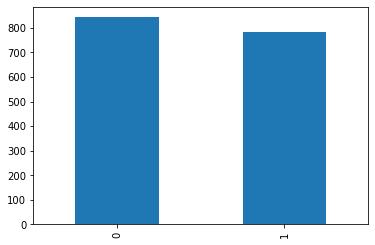

In [8]:
train_data['Attrition'].value_counts().plot(kind = 'bar')

We have more or less a balanced distribution. Lets check for duplciates

In [9]:
print('Number of duplicates: ',train_data.duplicated().sum())

Number of duplicates:  628


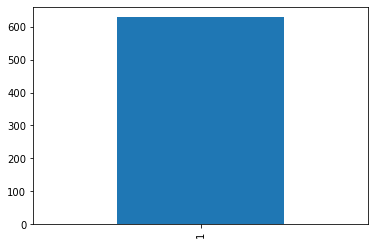

In [10]:
train_data[train_data.duplicated()]['Attrition'].value_counts().plot(kind = 'bar')

Alright, so the data has 628 duplicates and all the duplicates correspond to Attrition 1. So that means that data was oversampled to make it balanced. We will drop the duplicates now and check the distribution again.

New train set:  (1000, 27)


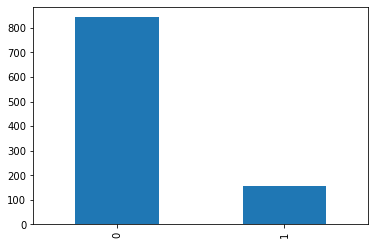

In [11]:
# drop them

train_unq = train_data.drop_duplicates()
print('New train set: ',train_unq.shape)
X = train_unq.drop('Attrition',axis = 1)
y = train_unq['Attrition']
y.value_counts().plot(kind = 'bar')
plt.show()

Now our training data has 1000 data points and the target variable is imbalanced. There are many ways to tackle imbalanced data sets like upsampling or downsampling using SMOTE.

We can also use a cross validation strategy such as stratified k-fold which keeps the distribution of our target variable (here Attrition) similar across the folds. The training and validation data is split using stratified sampling instead of random sampling. The stratas here are the two values of our target variable. If you don't understand what this means then don't worry about it just remember that it is an effective method to tackle imbalanced datasets while we train our model. You can learn more about it in the scikit-learn user guide for cross validation.

# Pre-Processing, Training and Validation


We will follow the following steps now:

- Drop performance rating (on exploration I found that 85% values were of a single class this might lead to overfitting)
- One Hot Encode all the 'object' data type features
- Use standard scaling on all the integer data type features.
- Use the pre-processed data and split it using Stratified K-Fold.
- Fit and validate with 3 candidate models: Random Forest, XGBoost and Support Vector Classifier

In [12]:
# Standard Scaling
skf = StratifiedKFold(n_splits = 10,random_state=42,shuffle=True)

categorical = [f for f in training.columns if training[f].dtype == object]
numeric = [f for f in X.columns if f not in categorical+['Id','Attrition','Behaviour','PerformanceRating']]

pre_pipe = make_column_transformer((OneHotEncoder(),categorical),(StandardScaler(),numeric))

Testing on 3 candidate models: Random Forest, XGBoost, Support Vector Machines

In [13]:
pipe_rf = make_pipeline(pre_pipe,RandomForestClassifier())
pipe_xgb = make_pipeline(pre_pipe,XGBClassifier())
pipe_svc = make_pipeline(pre_pipe,SVC(probability=True))


print('RF: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_rf,scoring='roc_auc')))
print('XGB: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_xgb,scoring='roc_auc')))
print('SVC:',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_svc,scoring='roc_auc')))

RF:  0.8044762780112045
XGB:  0.7940574229691877
SVC: 0.822673319327731


SVC performs best here - trying out PCA

SVC:  0.8192405462184873


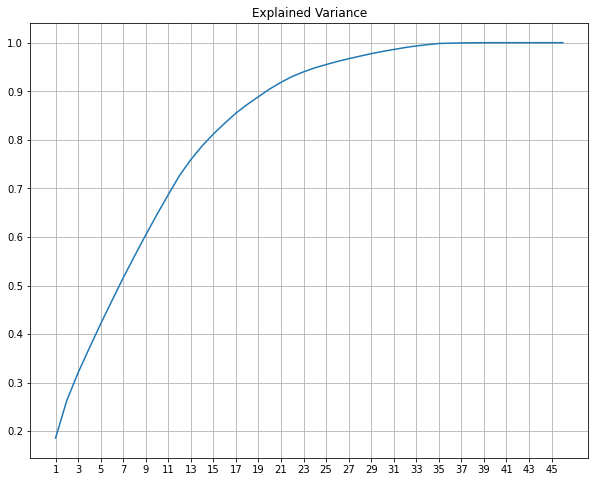

In [14]:
n = 46
pipe_svc = make_pipeline(pre_pipe,PCA(n_components=n),SVC(probability=True,C = 1,kernel='rbf'))
print('SVC: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_svc,scoring='roc_auc')))

plt.figure(figsize=(10,8))
pipe_svc.fit(X,y)
plt.plot(range(1,n+1),pipe_svc.named_steps['pca'].explained_variance_ratio_.cumsum())
plt.xticks(range(1,n+1,2))
plt.title('Explained Variance')
plt.grid()
plt.show()

34 components are explaining 100% of the variance

In [15]:
n = 34
pre_pipe = make_column_transformer((OneHotEncoder(),categorical),(StandardScaler(),numeric),remainder = 'passthrough')
pipe_svc = make_pipeline(pre_pipe,PCA(n_components=n),SVC(probability=True,C = 1,kernel='rbf'))
print('SVC: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_svc,scoring='roc_auc')))

SVC:  0.8196367296918767


Tuning SVC - using Grid Search

In [16]:
n = 34
pre_pipe = make_column_transformer((OneHotEncoder(),categorical),(StandardScaler(),numeric),remainder = 'passthrough')
pipe_svc = make_pipeline(pre_pipe,PCA(n_components=n),SVC(probability=True,C = 1,kernel = 'rbf'))

param_grid = {
    
    'svc__C':[0.001,0.01,0.1,1,10,100,1000],
    'svc__gamma': ['auto','scale'],
    'svc__class_weight': ['balanced',None]
}    

grid_search = GridSearchCV(pipe_svc,param_grid=param_grid,cv = skf, verbose=2, n_jobs = -1,scoring='roc_auc')
grid_search.fit(X,y)
print('Best score ',grid_search.best_score_)
print('Best parameters ',grid_search.best_params_)
best_svc = grid_search.best_estimator_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:   29.2s finished


Best score  0.8317690826330532
Best parameters  {'svc__C': 0.1, 'svc__class_weight': None, 'svc__gamma': 'auto'}


We can tune it further

In [17]:
pipe_svc = make_pipeline(pre_pipe,PCA(n_components=n),SVC(probability=True,C = 1,kernel='rbf',class_weight=None,gamma='auto'))
param_grid={
    'svc__C':[0.01,0.03,0.05,0.07,0.1,0.3,0.5,0.7,1]  
}
grid_search = GridSearchCV(pipe_svc,param_grid=param_grid,cv = skf, verbose=2, n_jobs = -1,scoring = 'roc_auc')
grid_search.fit(X,y)
print('Best score ',grid_search.best_score_)
print('Best parameters ',grid_search.best_params_)
best_svc = grid_search.best_estimator_ # final model - 0.808 private LB*

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    6.4s finished


Best score  0.8319178921568628
Best parameters  {'svc__C': 0.05}


Submission

In [18]:
best_svc.fit(X,y)
prediction = best_svc.predict_proba(test_data)[:,1]
submission = pd.DataFrame(prediction,columns=['Attrition'])
submission['Id'] = test_id
submission = submission[['Id','Attrition']]
submission.to_csv('submissionfile_postcomp.csv',index = None)

**If you liked this notebook and learnt something new from it do give an upvote. You can also checkout my [blog on medium](http://https://medium.com/@mishraarpan6) where I have given an in-depth explanation about Support Vector Machines and have provided a deeper dive into the code here with links to all the documentaion.**